In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.9.1 True


# Install Detectron 

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-hjx4rlax
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-hjx4rlax
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8ba4dd8dede399e73e931b95c1d61dcb7ecb21ae
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 106 kB 612 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     |████████████████████████████████| 49 kB 2.2 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 1.5 MB/s            
     |████████████████████████████████| 145 kB 3.4 MB/s            
     |████████████████████████████████| 130 kB 7.0 MB/s            
     |████████████████████████████████| 112 kB 7.0 MB/s    

# Importing Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd 

from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional
import json
import matplotlib.pyplot as plt

import ast


from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

from pycocotools.coco import COCO
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset



from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

setup_logger()


<_Logger detectron2 (DEBUG)>

# Load the Data 

In [4]:
df_train = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')

# Creating a COCO dataset

Now we convert all our data into the format that is required to make a COCO dataset to be used by our model

> **Annotations**

In [5]:
x_min = df_train['xmin']
y_min = df_train['ymin']
x_max = df_train['xmax']
y_max = df_train['ymax']
bboxes = list()
for i in range(len(x_min)):
    bboxes.append([[x_min[i],y_min[i],x_max[i],y_max[i]]])
df_train['bboxes'] = bboxes

> **Image height and width**

In [6]:
df_train["Width"]=676
df_train["Height"]=380
df_train.sample(2)

image        xmin        ymin        xmax        ymax  \
475   vid_4_8220.jpg  550.942462  178.632610  665.660597  220.964216   
134  vid_4_16680.jpg   60.654124  196.816281  212.778582  251.591055   

                                                bboxes  Width  Height  
475  [[550.9424618, 178.6326101, 665.6605972, 220.9...    676     380  
134  [[60.65412446, 196.8162806, 212.7785818, 251.5...    676     380

> **Image path**

In [7]:
train_path = '../input/car-object-detection/data/training_images/'
path = list()
for i in df_train['image']:
    path.append(train_path + i )

In [8]:
df_train['image_path'] = path
df_train.sample(2)

image        xmin        ymin        xmax        ymax  \
325  vid_4_26440.jpg  361.479016  188.013192  484.254703  228.116152   
71   vid_4_13640.jpg    0.000000  195.349099  130.112880  252.080116   

                                                bboxes  Width  Height  \
325  [[361.4790159, 188.0131918, 484.2547033, 228.1...    676     380   
71      [[0.0, 195.3490991, 130.1128799, 252.0801158]]    676     380   

                                            image_path  
325  ../input/car-object-detection/data/training_im...  
71   ../input/car-object-detection/data/training_im...

> **Image Id**

In [9]:
id = list()
for i in df_train['image']:
    id.append(i[:-4])

In [10]:
df_train['image_id'] = id
df_train.sample(2)

image        xmin        ymin        xmax        ymax  \
223  vid_4_2020.jpg  601.160637  179.210103  676.000000  224.692728   
210  vid_4_1980.jpg  351.696093  189.969434  449.525326  231.539575   

                                                bboxes  Width  Height  \
223    [[601.1606368, 179.210103, 676.0, 224.6927284]]    676     380   
210  [[351.6960926, 189.9694337, 449.5253256, 231.5...    676     380   

                                            image_path    image_id  
223  ../input/car-object-detection/data/training_im...  vid_4_2020  
210  ../input/car-object-detection/data/training_im...  vid_4_1980

# Split the Data

In [11]:
n_spl=3
Selected_Fold=2 #0..2

from sklearn.model_selection import GroupKFold
gkf  = GroupKFold(n_splits = n_spl) # num_folds=3 as there are total 3 videos
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups = df_train.image_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

0    187
1    186
2    186
Name: fold, dtype: int64

Here is where we begin to create the COCO dataset for our model

In [12]:
def get_data_dicts(
    _train_df: pd.DataFrame,
    debug: bool = False,
    data_type:str="train"
   
):

    if debug:
        _train_df = _train_df.iloc[:10]  # For debug...
    dataset_dicts = []
    if data_type=="train":
        _train_df=_train_df[_train_df.fold != Selected_Fold]
    else: # val
        _train_df=_train_df[_train_df.fold == Selected_Fold] 
        
    for index, row in tqdm(_train_df.iterrows(), total=len(_train_df)):
        record = {}
        filename  = row.image_path #filename = str(f'{imgdir}/{image_id}.png')
        image_id = row.image_id
        image_height= row.Height
        image_width = row.Width
        bboxes_coco = row.bboxes
        #bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
        record["file_name"] = filename
        record["image_id"] = image_id
        record["width"] = image_width
        record["height"] = image_height
        objs = []
        class_id = 0
        for bbox_idx in range(len(bboxes_coco)):
            bbox=bboxes_coco[bbox_idx]
            obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
            objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [13]:
thing_classes=['car']
debug=False

Data_Resister_training="BR_data_train2";
Data_Resister_valid="BR_data_valid2";


DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    

dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

100%|██████████| 186/186 [00:00<00:00, 11129.44it/s]


# Visulaise the Bounding Boxes

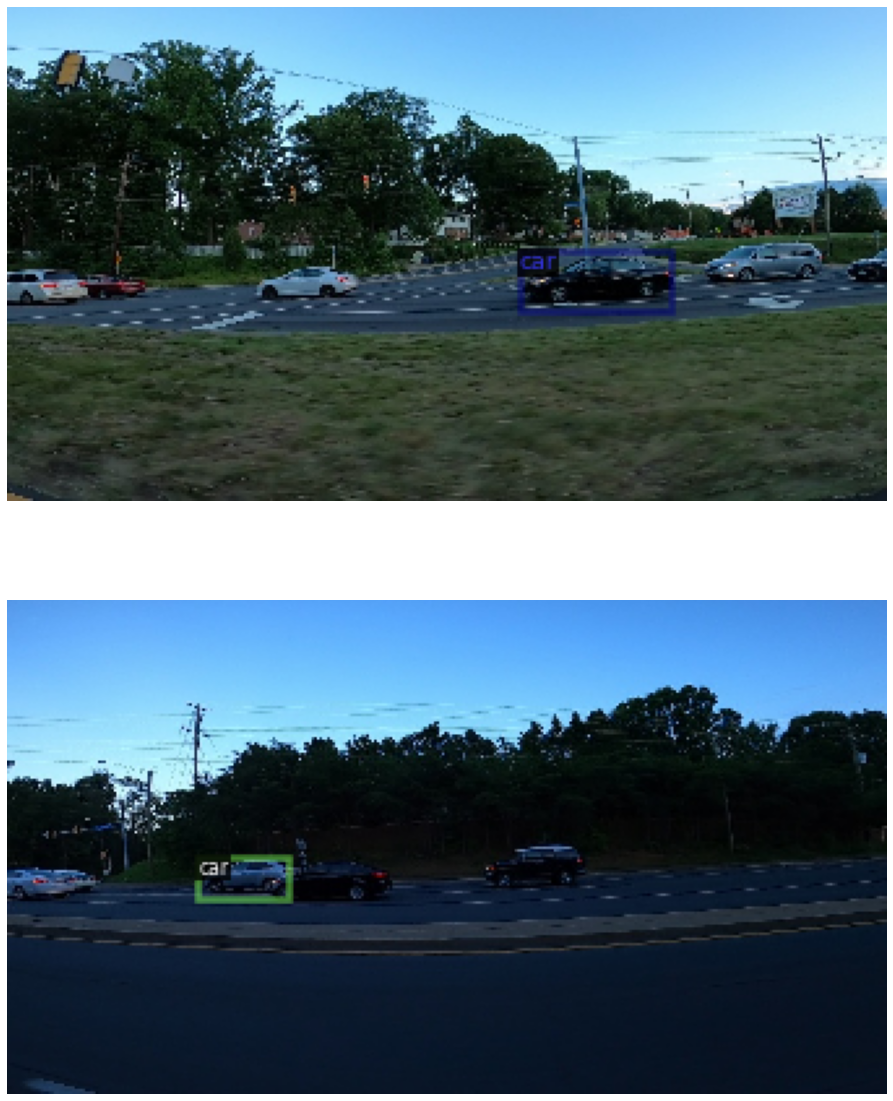

In [14]:
fig, ax = plt.subplots(2, 1, figsize =(35,20))
i=-1
for d in random.sample(dataset_dicts_train, 2):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, :],
                   metadata=metadata_dicts_train, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].imshow(out.get_image()[:, :, ::-1])

# LossEvalHook

In [15]:
import logging
import numpy as np
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self._model = model
        self._period = cfg.TEST.EVAL_PERIOD
        self._root = cfg.OUTPUT_DIR
        self._data_loader = data_loader
        self._min_mean_loss = 0.0
        self._bfirst = True
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return mean_loss
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
                
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            if self._bfirst:
                self._min_mean_loss = mean_loss
                self._bfirst = False
            #-------- save best model according to metrics --------
            if mean_loss < self._min_mean_loss:
                self._min_mean_loss = mean_loss
                self.trainer.checkpointer.save('model_best')
                with open('bestiter.txt', 'a+') as f:
                    f.write('min val loss: ' + str(mean_loss) + ' at iter: ' + str(self.trainer.iter) + '\n')

In [16]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name,("bbox",), True, output_folder)
        #return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
        #return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

# Train the model

In [17]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"  

cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="../input/brdetectron2l/output/model_best.pth" 

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 64 is slower but more accurate (128 faster but less accurate)


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class  + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class  + 1

cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.1

    
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 800 #Maximum of iterations 1
cfg.SOLVER.STEPS = (200,400,750) #At which point to change the LR 0.25,0.5

cfg.TEST.EVAL_PERIOD = 60
#cfg.SOLVER.CHECKPOINT_PERIOD=100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()


[01/12 11:07:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 373/373 [00:00<00:00, 10350.07it/s]

[01/12 11:07:59 d2.data.build]: Removed 0 images with no usable annotations. 373 images left.
[01/12 11:07:59 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    car     | 373          |
|            |              |
[01/12 11:07:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/12 11:07:59 d2.data.build]: Using training sampler TrainingSampler
[01/12 11:07:59 d2.data.common]: Serializing 373 elements to byte tensors and concatenating them all ...
[01/12 11:07:59 d2.data.common]: Serialized dataset takes 0.15 MiB


[01/12 11:08:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


100%|██████████| 186/186 [00:00<00:00, 10583.34it/s]

[01/12 11:08:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    car     | 186          |
|            |              |
[01/12 11:08:02 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:08:02 d2.data.common]: Serialized dataset takes 0.07 MiB



model_final_280758.pkl: 167MB [00:10, 15.4MB/s]                           


[01/12 11:08:15 d2.engine.train_loop]: Starting training from iteration 0
[01/12 11:08:26 d2.utils.events]:  eta: 0:03:46  iter: 19  total_loss: 0.8935  loss_cls: 0.3914  loss_box_reg: 0.444  loss_rpn_cls: 0.009961  loss_rpn_loc: 0.004914  time: 0.2811  data_time: 0.0152  lr: 0.0005  max_mem: 2640M
[01/12 11:08:32 d2.utils.events]:  eta: 0:03:41  iter: 39  total_loss: 0.6556  loss_cls: 0.1529  loss_box_reg: 0.4695  loss_rpn_cls: 0.004154  loss_rpn_loc: 0.003443  time: 0.2835  data_time: 0.0066  lr: 0.0005  max_mem: 2640M


100%|██████████| 186/186 [00:00<00:00, 10863.35it/s]

[01/12 11:08:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:08:38 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:08:38 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:08:38 d2.evaluation.coco_evaluation]: Trying to convert 'BR_data_valid2' to COCO format ...
[01/12 11:08:38 d2.data.datasets.coco]: Converting annotations of dataset 'BR_data_valid2' to COCO format ...)



100%|██████████| 186/186 [00:00<00:00, 11094.15it/s]

[01/12 11:08:38 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/12 11:08:38 d2.data.datasets.coco]: Conversion finished, #images: 186, #annotations: 186
[01/12 11:08:38 d2.data.datasets.coco]: Caching COCO format annotations at './output/inference/BR_data_valid2_coco_format.json' ...
[01/12 11:08:38 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:08:39 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0016 s/iter. Inference: 0.0678 s/iter. Eval: 0.0002 s/iter. Total: 0.0696 s/iter. ETA=0:00:12
[01/12 11:08:44 d2.evaluation.evaluator]: Inference done 82/186. Dataloading: 0.0023 s/iter. Inference: 0.0685 s/iter. Eval: 0.0002 s/iter. Total: 0.0712 s/iter. ETA=0:00:07
[01/12 11:08:49 d2.evaluation.evaluator]: Inference done 151/186. Dataloading: 0.0024 s/iter. Inference: 0.0692 s/iter. Eval: 0.0002 s/iter. Total: 0.0719 s/iter. ETA=0:00:02
[01/12 11:08:51 d2.evaluation.evaluator]: Total inference time: 0:00:13.023993 (0.071956 s / iter per device, on 1 devices)
[01/12 11:08:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068832 s / iter per device, on 1 devices)
[01/12 11:08:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:08:51 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:08:52 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11612.86it/s]

[01/12 11:09:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:09:23 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:09:23 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:09:23 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:09:24 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0012 s/iter. Inference: 0.0671 s/iter. Eval: 0.0002 s/iter. Total: 0.0686 s/iter. ETA=0:00:11
[01/12 11:09:29 d2.evaluation.evaluator]: Inference done 80/186. Dataloading: 0.0027 s/iter. Inference: 0.0697 s/iter. Eval: 0.0002 s/iter. Total: 0.0728 s/iter. ETA=0:00:07
[01/12 11:09:34 d2.evaluation.evaluator]: Inference done 152/186. Dataloading: 0.0025 s/iter. Inference: 0.0687 s/iter. Eval: 0.0002 s/iter. Total: 0.0715 s/iter. ETA=0:00:02
[01/12 11:09:36 d2.evaluation.evaluator]: Total inference time: 0:00:13.020131 (0.071934 s / iter per device, on 1 devices)
[01/12 11:09:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068852 s / iter per device, on 1 devices)
[01/12 11:09:36 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:09:36 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:09:36 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11820.85it/s]

[01/12 11:10:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:10:08 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:10:08 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:10:08 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:10:09 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0066 s/iter. Inference: 0.0718 s/iter. Eval: 0.0002 s/iter. Total: 0.0786 s/iter. ETA=0:00:13
[01/12 11:10:14 d2.evaluation.evaluator]: Inference done 83/186. Dataloading: 0.0021 s/iter. Inference: 0.0678 s/iter. Eval: 0.0002 s/iter. Total: 0.0702 s/iter. ETA=0:00:07
[01/12 11:10:19 d2.evaluation.evaluator]: Inference done 155/186. Dataloading: 0.0020 s/iter. Inference: 0.0677 s/iter. Eval: 0.0002 s/iter. Total: 0.0701 s/iter. ETA=0:00:02
[01/12 11:10:21 d2.evaluation.evaluator]: Total inference time: 0:00:12.936075 (0.071470 s / iter per device, on 1 devices)
[01/12 11:10:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068552 s / iter per device, on 1 devices)
[01/12 11:10:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:10:21 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:10:21 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 10988.51it/s]

[01/12 11:10:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:10:55 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:10:55 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:10:55 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:10:56 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0675 s/iter. Eval: 0.0002 s/iter. Total: 0.0691 s/iter. ETA=0:00:12
[01/12 11:11:01 d2.evaluation.evaluator]: Inference done 78/186. Dataloading: 0.0031 s/iter. Inference: 0.0709 s/iter. Eval: 0.0002 s/iter. Total: 0.0743 s/iter. ETA=0:00:08
[01/12 11:11:06 d2.evaluation.evaluator]: Inference done 148/186. Dataloading: 0.0028 s/iter. Inference: 0.0698 s/iter. Eval: 0.0002 s/iter. Total: 0.0729 s/iter. ETA=0:00:02
[01/12 11:11:09 d2.evaluation.evaluator]: Total inference time: 0:00:13.171535 (0.072771 s / iter per device, on 1 devices)
[01/12 11:11:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.069444 s / iter per device, on 1 devices)
[01/12 11:11:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:11:09 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:11:09 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 10547.43it/s]

[01/12 11:11:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:11:42 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:11:42 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:11:42 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:11:43 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0015 s/iter. Inference: 0.0675 s/iter. Eval: 0.0002 s/iter. Total: 0.0692 s/iter. ETA=0:00:12
[01/12 11:11:48 d2.evaluation.evaluator]: Inference done 81/186. Dataloading: 0.0024 s/iter. Inference: 0.0689 s/iter. Eval: 0.0002 s/iter. Total: 0.0716 s/iter. ETA=0:00:07
[01/12 11:11:53 d2.evaluation.evaluator]: Inference done 153/186. Dataloading: 0.0022 s/iter. Inference: 0.0683 s/iter. Eval: 0.0002 s/iter. Total: 0.0708 s/iter. ETA=0:00:02
[01/12 11:11:56 d2.evaluation.evaluator]: Total inference time: 0:00:12.841664 (0.070948 s / iter per device, on 1 devices)
[01/12 11:11:56 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068225 s / iter per device, on 1 devices)
[01/12 11:11:56 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:11:56 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:11:56 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 10881.53it/s]

[01/12 11:12:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:12:29 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:12:29 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:12:29 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:12:30 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0673 s/iter. Eval: 0.0002 s/iter. Total: 0.0689 s/iter. ETA=0:00:12
[01/12 11:12:35 d2.evaluation.evaluator]: Inference done 80/186. Dataloading: 0.0026 s/iter. Inference: 0.0698 s/iter. Eval: 0.0002 s/iter. Total: 0.0727 s/iter. ETA=0:00:07
[01/12 11:12:40 d2.evaluation.evaluator]: Inference done 147/186. Dataloading: 0.0030 s/iter. Inference: 0.0703 s/iter. Eval: 0.0002 s/iter. Total: 0.0737 s/iter. ETA=0:00:02
[01/12 11:12:43 d2.evaluation.evaluator]: Total inference time: 0:00:13.322749 (0.073606 s / iter per device, on 1 devices)
[01/12 11:12:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.070032 s / iter per device, on 1 devices)
[01/12 11:12:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:12:43 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:12:43 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11805.82it/s]

[01/12 11:13:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:13:14 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:13:14 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:13:14 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:13:15 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0027 s/iter. Inference: 0.0708 s/iter. Eval: 0.0003 s/iter. Total: 0.0738 s/iter. ETA=0:00:12
[01/12 11:13:20 d2.evaluation.evaluator]: Inference done 81/186. Dataloading: 0.0025 s/iter. Inference: 0.0691 s/iter. Eval: 0.0002 s/iter. Total: 0.0719 s/iter. ETA=0:00:07
[01/12 11:13:25 d2.evaluation.evaluator]: Inference done 153/186. Dataloading: 0.0022 s/iter. Inference: 0.0684 s/iter. Eval: 0.0002 s/iter. Total: 0.0709 s/iter. ETA=0:00:02
[01/12 11:13:28 d2.evaluation.evaluator]: Total inference time: 0:00:12.969513 (0.071655 s / iter per device, on 1 devices)
[01/12 11:13:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068662 s / iter per device, on 1 devices)
[01/12 11:13:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:13:28 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:13:28 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11193.96it/s]

[01/12 11:13:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:13:59 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:13:59 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:13:59 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:14:00 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0026 s/iter. Inference: 0.0705 s/iter. Eval: 0.0002 s/iter. Total: 0.0733 s/iter. ETA=0:00:12
[01/12 11:14:05 d2.evaluation.evaluator]: Inference done 83/186. Dataloading: 0.0018 s/iter. Inference: 0.0677 s/iter. Eval: 0.0002 s/iter. Total: 0.0697 s/iter. ETA=0:00:07
[01/12 11:14:10 d2.evaluation.evaluator]: Inference done 154/186. Dataloading: 0.0021 s/iter. Inference: 0.0680 s/iter. Eval: 0.0002 s/iter. Total: 0.0703 s/iter. ETA=0:00:02
[01/12 11:14:13 d2.evaluation.evaluator]: Total inference time: 0:00:12.823055 (0.070846 s / iter per device, on 1 devices)
[01/12 11:14:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068075 s / iter per device, on 1 devices)
[01/12 11:14:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:14:13 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:14:13 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11895.11it/s]

[01/12 11:14:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:14:46 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:14:46 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:14:46 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:14:47 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0676 s/iter. Eval: 0.0002 s/iter. Total: 0.0692 s/iter. ETA=0:00:12
[01/12 11:14:52 d2.evaluation.evaluator]: Inference done 80/186. Dataloading: 0.0030 s/iter. Inference: 0.0698 s/iter. Eval: 0.0002 s/iter. Total: 0.0731 s/iter. ETA=0:00:07
[01/12 11:14:57 d2.evaluation.evaluator]: Inference done 149/186. Dataloading: 0.0032 s/iter. Inference: 0.0696 s/iter. Eval: 0.0002 s/iter. Total: 0.0731 s/iter. ETA=0:00:02
[01/12 11:15:00 d2.evaluation.evaluator]: Total inference time: 0:00:13.168656 (0.072755 s / iter per device, on 1 devices)
[01/12 11:15:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.069251 s / iter per device, on 1 devices)
[01/12 11:15:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:15:00 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:15:00 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11347.33it/s]

[01/12 11:15:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:15:33 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:15:33 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:15:33 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:15:34 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0674 s/iter. Eval: 0.0002 s/iter. Total: 0.0690 s/iter. ETA=0:00:12
[01/12 11:15:39 d2.evaluation.evaluator]: Inference done 81/186. Dataloading: 0.0025 s/iter. Inference: 0.0691 s/iter. Eval: 0.0003 s/iter. Total: 0.0720 s/iter. ETA=0:00:07
[01/12 11:15:45 d2.evaluation.evaluator]: Inference done 153/186. Dataloading: 0.0022 s/iter. Inference: 0.0685 s/iter. Eval: 0.0003 s/iter. Total: 0.0710 s/iter. ETA=0:00:02
[01/12 11:15:47 d2.evaluation.evaluator]: Total inference time: 0:00:12.875243 (0.071134 s / iter per device, on 1 devices)
[01/12 11:15:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068443 s / iter per device, on 1 devices)
[01/12 11:15:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:15:47 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:15:47 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11692.58it/s]

[01/12 11:16:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:16:19 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:16:19 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:16:19 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:16:20 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0015 s/iter. Inference: 0.0675 s/iter. Eval: 0.0002 s/iter. Total: 0.0692 s/iter. ETA=0:00:12
[01/12 11:16:25 d2.evaluation.evaluator]: Inference done 82/186. Dataloading: 0.0025 s/iter. Inference: 0.0684 s/iter. Eval: 0.0002 s/iter. Total: 0.0712 s/iter. ETA=0:00:07
[01/12 11:16:30 d2.evaluation.evaluator]: Inference done 149/186. Dataloading: 0.0031 s/iter. Inference: 0.0695 s/iter. Eval: 0.0002 s/iter. Total: 0.0730 s/iter. ETA=0:00:02
[01/12 11:16:32 d2.evaluation.evaluator]: Total inference time: 0:00:13.149029 (0.072647 s / iter per device, on 1 devices)
[01/12 11:16:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.069192 s / iter per device, on 1 devices)
[01/12 11:16:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:16:32 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:16:32 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 7020.89it/s]

[01/12 11:17:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:17:04 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:17:04 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:17:04 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:17:05 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0680 s/iter. Eval: 0.0002 s/iter. Total: 0.0696 s/iter. ETA=0:00:12
[01/12 11:17:10 d2.evaluation.evaluator]: Inference done 80/186. Dataloading: 0.0030 s/iter. Inference: 0.0694 s/iter. Eval: 0.0002 s/iter. Total: 0.0726 s/iter. ETA=0:00:07
[01/12 11:17:15 d2.evaluation.evaluator]: Inference done 152/186. Dataloading: 0.0024 s/iter. Inference: 0.0685 s/iter. Eval: 0.0002 s/iter. Total: 0.0711 s/iter. ETA=0:00:02
[01/12 11:17:17 d2.evaluation.evaluator]: Total inference time: 0:00:12.922252 (0.071394 s / iter per device, on 1 devices)
[01/12 11:17:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068412 s / iter per device, on 1 devices)
[01/12 11:17:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:17:17 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:17:17 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11871.21it/s]

[01/12 11:17:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:17:49 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:17:49 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:17:49 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:17:50 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0019 s/iter. Inference: 0.0680 s/iter. Eval: 0.0002 s/iter. Total: 0.0702 s/iter. ETA=0:00:12
[01/12 11:17:55 d2.evaluation.evaluator]: Inference done 81/186. Dataloading: 0.0023 s/iter. Inference: 0.0689 s/iter. Eval: 0.0002 s/iter. Total: 0.0714 s/iter. ETA=0:00:07
[01/12 11:18:00 d2.evaluation.evaluator]: Inference done 152/186. Dataloading: 0.0023 s/iter. Inference: 0.0685 s/iter. Eval: 0.0002 s/iter. Total: 0.0711 s/iter. ETA=0:00:02
[01/12 11:18:02 d2.evaluation.evaluator]: Total inference time: 0:00:12.999236 (0.071819 s / iter per device, on 1 devices)
[01/12 11:18:02 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068701 s / iter per device, on 1 devices)
[01/12 11:18:02 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:18:02 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:18:02 d2.evalu

100%|██████████| 186/186 [00:00<00:00, 11397.57it/s]

[01/12 11:18:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:18:37 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:18:37 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:18:37 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:18:38 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0031 s/iter. Inference: 0.0686 s/iter. Eval: 0.0002 s/iter. Total: 0.0719 s/iter. ETA=0:00:12
[01/12 11:18:43 d2.evaluation.evaluator]: Inference done 78/186. Dataloading: 0.0040 s/iter. Inference: 0.0702 s/iter. Eval: 0.0002 s/iter. Total: 0.0745 s/iter. ETA=0:00:08
[01/12 11:18:48 d2.evaluation.evaluator]: Inference done 146/186. Dataloading: 0.0040 s/iter. Inference: 0.0700 s/iter. Eval: 0.0002 s/iter. Total: 0.0743 s/iter. ETA=0:00:02
[01/12 11:18:51 d2.evaluation.evaluator]: Total inference time: 0:00:13.335757 (0.073678 s / iter per device, on 1 devices)
[01/12 11:18:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.069572 s / iter per device, on 1 devices)
[01/12 11:18:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:18:51 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[01/12 11:18:51 d2.evalu

# Evaluate the model

In [18]:
print('test model final:')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(Data_Resister_valid,  False, output_dir="./output_final/")
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
print(inference_on_dataset(trainer.model, val_loader, evaluator))


print('test model best:')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth") 
#cfg.MODEL.WEIGHTS="./output/model_best.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(Data_Resister_valid, False, output_dir="./output_best/") #bbox
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
print(inference_on_dataset(trainer.model, val_loader, evaluator))

test model final:


100%|██████████| 186/186 [00:00<00:00, 11991.09it/s]

[01/12 11:18:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:18:53 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:18:53 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:18:53 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:18:54 d2.evaluation.evaluator]: Inference done 11/186. Dataloading: 0.0014 s/iter. Inference: 0.0679 s/iter. Eval: 0.0002 s/iter. Total: 0.0695 s/iter. ETA=0:00:12
[01/12 11:18:59 d2.evaluation.evaluator]: Inference done 80/186. Dataloading: 0.0025 s/iter. Inference: 0.0695 s/iter. Eval: 0.0002 s/iter. Total: 0.0724 s/iter. ETA=0:00:07
[01/12 11:19:04 d2.evaluation.evaluator]: Inference done 152/186. Dataloading: 0.0022 s/iter. Inference: 0.0686 s/iter. Eval: 0.0002 s/iter. Total: 0.0711 s/iter. ETA=0:00:02
[01/12 11:19:06 d2.evaluation.evaluator]: Total inference time: 0:00:12.861238 (0.071057 s / iter per device, on 1 devices)
[01/12 11:19:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.068423 s / iter per device, on 1 devices)
[01/12 11:19:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:19:06 d2.evaluation.coco_evaluation]: Saving results to ./output_final/coco_instances_results.json
[01/12 11:19:06 d2.evaluatio

100%|██████████| 186/186 [00:00<00:00, 7438.41it/s]

[01/12 11:19:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/12 11:19:07 d2.data.common]: Serializing 186 elements to byte tensors and concatenating them all ...
[01/12 11:19:07 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/12 11:19:07 d2.evaluation.evaluator]: Start inference on 186 batches


[01/12 11:19:09 d2.evaluation.evaluator]: Inference done 18/186. Dataloading: 0.0014 s/iter. Inference: 0.0675 s/iter. Eval: 0.0002 s/iter. Total: 0.0692 s/iter. ETA=0:00:11
[01/12 11:19:14 d2.evaluation.evaluator]: Inference done 87/186. Dataloading: 0.0029 s/iter. Inference: 0.0694 s/iter. Eval: 0.0002 s/iter. Total: 0.0726 s/iter. ETA=0:00:07
[01/12 11:19:19 d2.evaluation.evaluator]: Inference done 156/186. Dataloading: 0.0027 s/iter. Inference: 0.0695 s/iter. Eval: 0.0002 s/iter. Total: 0.0726 s/iter. ETA=0:00:02
[01/12 11:19:21 d2.evaluation.evaluator]: Total inference time: 0:00:13.118779 (0.072479 s / iter per device, on 1 devices)
[01/12 11:19:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.069234 s / iter per device, on 1 devices)
[01/12 11:19:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/12 11:19:21 d2.evaluation.coco_evaluation]: Saving results to ./output_best/coco_instances_results.json
[01/12 11:19:21 d2.evaluation

# Plot the performance of the model

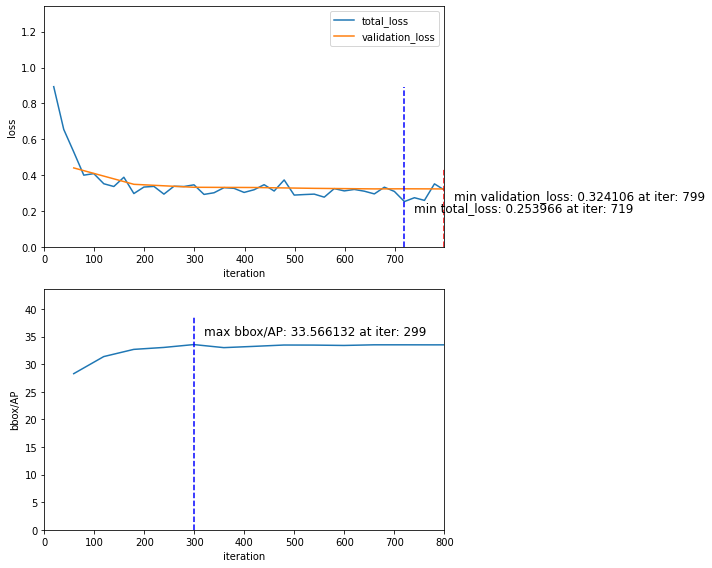

In [19]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines
experiment_metrics = load_json_arr('./output/metrics.json')

iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]


iters_validation_loss = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
validation_loss = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]

iters_AP = [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x]
AP = [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x]

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(iters_total_loss, total_loss)
ax[0].plot(iters_validation_loss, validation_loss)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend(['total_loss', 'validation_loss'], loc='best')

iter = validation_loss.index(min(validation_loss))
ax[0].vlines(iters_validation_loss[iter], 0, float(max(validation_loss)),color="red",linestyles ="dashed")
ax[0].annotate('min validation_loss: %f at iter: %d'%(float(min(validation_loss)),int(iters_validation_loss[iter])),xy=(iters_validation_loss[iter],min(validation_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

iter = total_loss.index(min(total_loss))
ax[0].vlines(iters_total_loss[iter], 0, float(max(total_loss)),color="blue",linestyles ="dashed")
ax[0].annotate('min total_loss: %f at iter: %d'%(float(min(total_loss)),int(iters_total_loss[iter])),xy=(iters_total_loss[iter],min(total_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_validation_loss))])
ax[0].set_ylim([0,max(1.5*max(total_loss),1.5*max(validation_loss))])
#ax[0].legend(bbox_to_anchor=(1.0, 1.0))

ax[1].plot(iters_AP, AP)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('bbox/AP')
iter = AP.index(max(AP))
ax[1].vlines(iters_AP[iter], 0, 5+float(max(AP)),color="blue",linestyles ="dashed")
ax[1].annotate('max bbox/AP: %f at iter: %d'%(float(max(AP)),int(iters_AP[iter])),xy=(iters_AP[iter],max(AP)),xytext=(+10,+10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
ax[1].set_xlim([0,max(iters_AP)])
ax[1].set_ylim([0,max(AP)*1.3])

fig.tight_layout()  
plt.show()

COCOEvaluator calculates AP with IoU from 0.50 to 0.95

# Predictions of the model

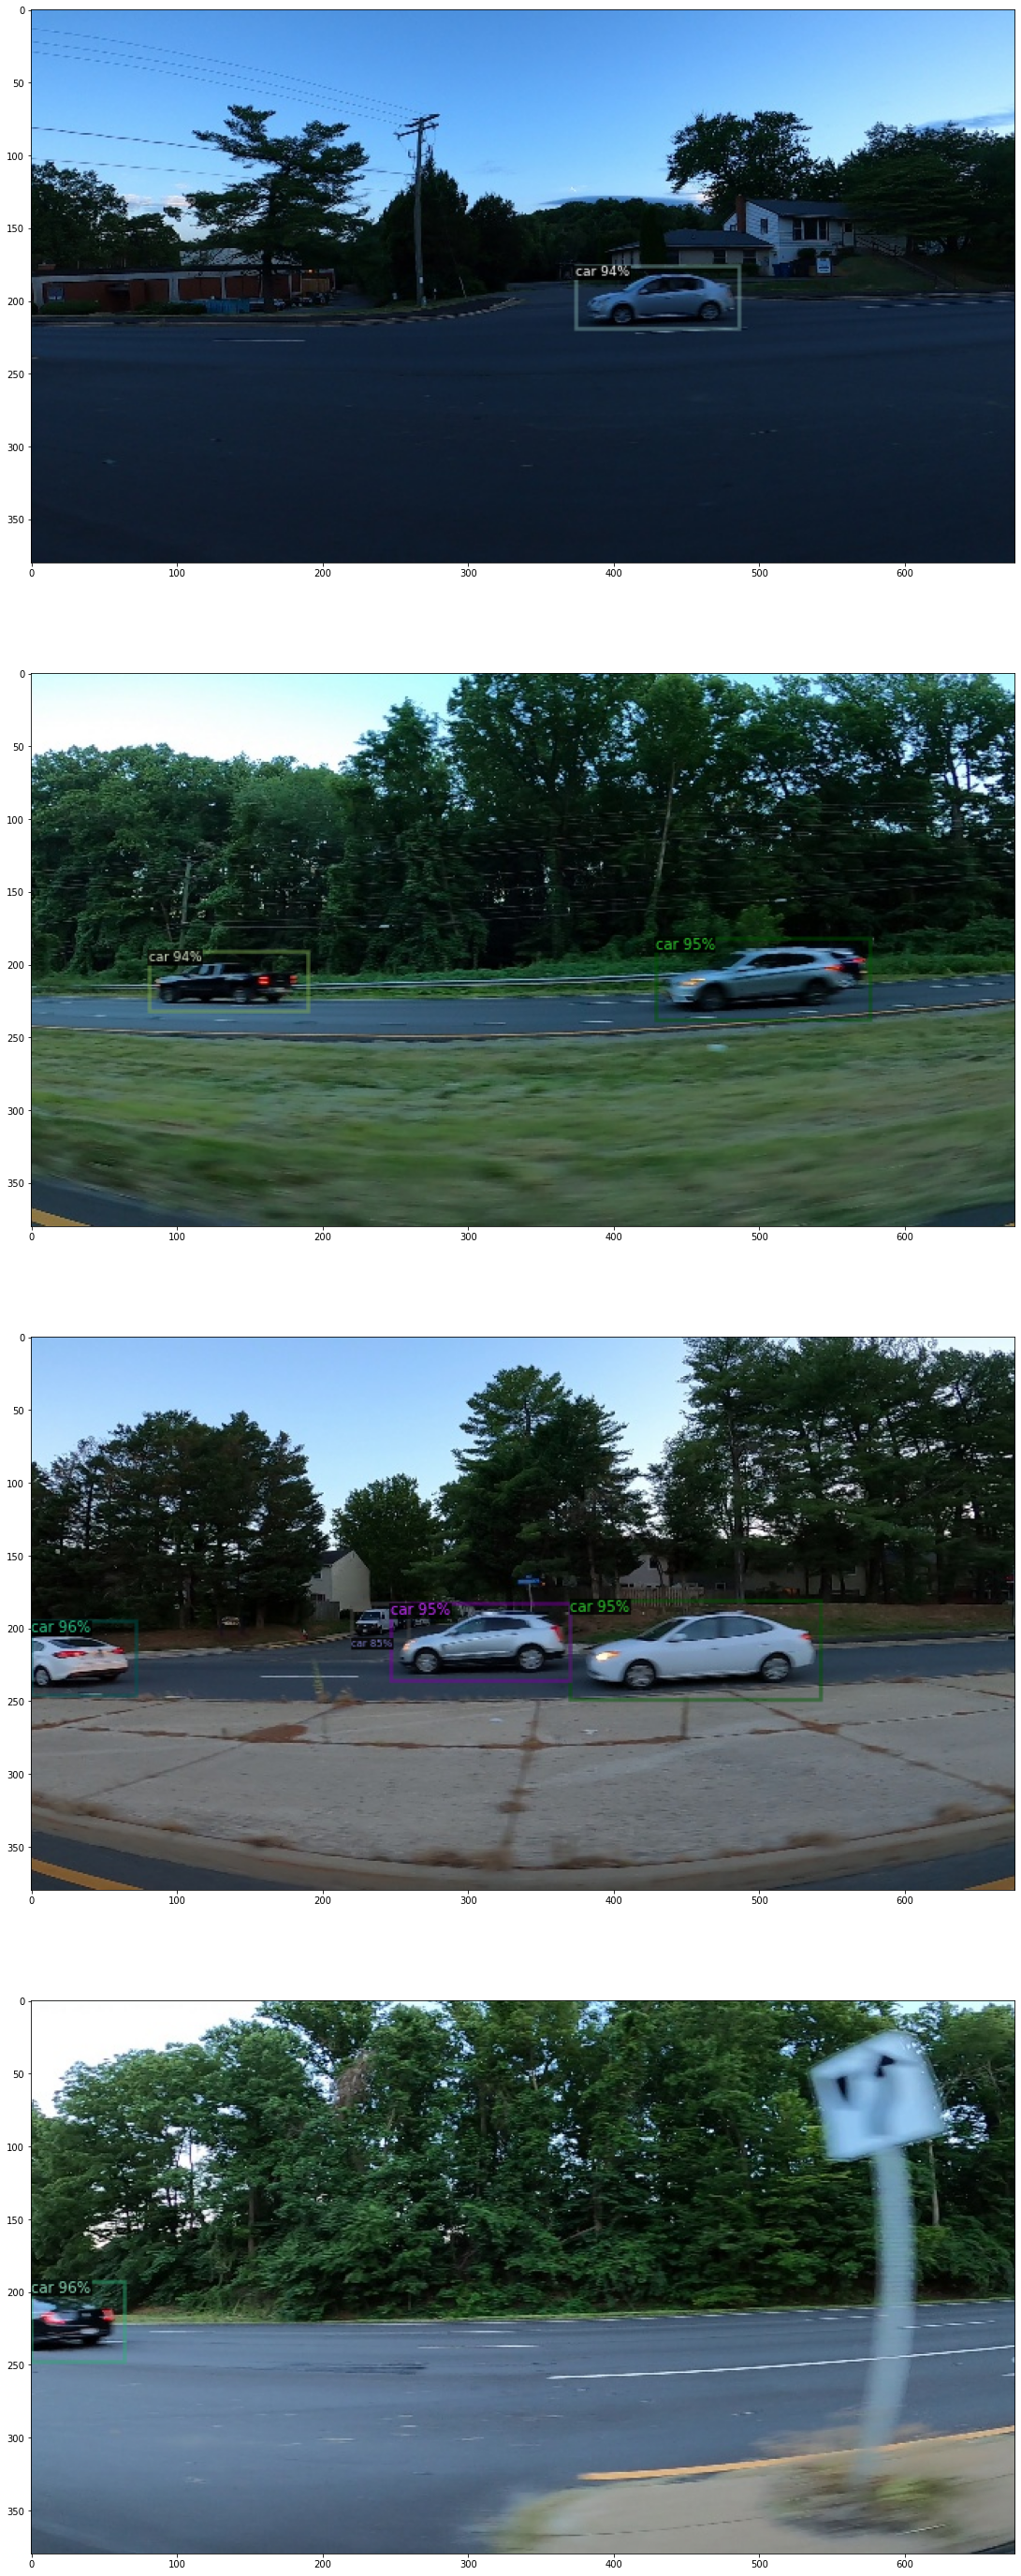

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor = DefaultPredictor(cfg)

fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_dicts_valid, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, :],
                   metadata=metadata_dicts_valid, 
                   scale=1 # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

# References

1. https://www.kaggle.com/ammarnassanalhajali/barrier-reef-detectron2-training/notebook
2. https://github.com/aakarsh7599/Text-Detection-using-Detectron2